<a href="https://colab.research.google.com/github/EmanueleCosenza/Polyphemus/blob/main/midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/home/cosenza/thesis/Polyphemus


Libraries installation

In [2]:
#!tar -C data -xvzf data/lmd_matched.tar.gz

In [3]:
# Install the required music libraries
#!pip3 install muspy
#!pip3 install pypianoroll

In [4]:
# Install torch_geometric
#!v=$(python3 -c "import torch; print(torch.__version__)"); \
#pip3 install torch-scatter -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-sparse -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-geometric

Reproducibility

In [5]:
import numpy as np
import torch
import random
import os

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
set_seed(seed)

In [6]:
import os
import muspy
from itertools import product
import pypianoroll as pproll
import time


class MIDIPreprocessor():
    
    def __init__():
        pass

    def preprocess_dataset(self, dir, early_exit=None):
        pass
    
    def preprocess_file(self, f):
        pass


# Todo: to config file (or separate files)
MAX_SIMU_NOTES = 16 # 14 + SOS and EOS

PITCH_SOS = 128
PITCH_EOS = 129
PITCH_PAD = 130
DUR_PAD_IND = 2
MAX_DUR = 511 # equivalent to 16 bars (with RESOLUTION=32)

RESOLUTION = 32
NUM_BARS = 1


def preprocess_file(filepath, dest_dir, num_samples):

    saved_samples = 0

    print()
    print("Preprocessing file " + filepath)

    # Load the file both as a pypianoroll song and a muspy song
    # (Need to load both since muspy.to_pypianoroll() is expensive)
    try:
        pproll_song = pproll.read(filepath, resolution=RESOLUTION)
        muspy_song = muspy.read(filepath)
    except Exception as e:
        print("Song skipped (Invalid song format)")
        return 0
    
    # Only accept songs that have a time signature of 4/4 and no time changes
    for t in muspy_song.time_signatures:
        if t.numerator != 4 or t.denominator != 4:
            print("Song skipped ({}/{} time signature)".
                            format(t.numerator, t.denominator))
            return 0

    # Gather tracks of pypianoroll song based on MIDI program number
    drum_tracks = []
    bass_tracks = []
    guitar_tracks = []
    strings_tracks = []

    for track in pproll_song.tracks:
        if track.is_drum:
            track.name = 'Drums'
            drum_tracks.append(track)
        elif 0 <= track.program <= 31:
            track.name = 'Guitar'
            guitar_tracks.append(track)
        elif 32 <= track.program <= 39:
            track.name = 'Bass'
            bass_tracks.append(track)
        else:
            # Tracks with program > 39 are all considered as strings tracks
            # and will be merged into a single track later on
            strings_tracks.append(track)

    # Filter song if it does not contain drum, guitar, bass or strings tracks
    if not drum_tracks or not guitar_tracks \
       or not bass_tracks or not strings_tracks:
        print("Song skipped (does not contain drum or "
                "guitar or bass or strings tracks)")
        return 0
    
    # Merge strings tracks into a single pypianoroll track
    strings = pproll.Multitrack(tracks=strings_tracks)
    strings_track = pproll.Track(pianoroll=strings.blend(mode='max'),
                                 program=48, name='Strings')

    combinations = list(product(drum_tracks, bass_tracks, guitar_tracks))

    # Single instruments can have multiple tracks.
    # Consider all possible combinations of drum, bass, and guitar tracks
    for i, combination in enumerate(combinations):

        print("Processing combination", i+1, "of", len(combinations))
        
        # Process combination (called 'subsong' from now on)
        drum_track, bass_track, guitar_track = combination
        tracks = [drum_track, bass_track, guitar_track, strings_track]
        
        pproll_subsong = pproll.Multitrack(
            tracks=tracks,
            tempo=pproll_song.tempo,
            resolution=RESOLUTION
        )
        muspy_subsong = muspy.from_pypianoroll(pproll_subsong)
        
        tracks_notes = [track.notes for track in muspy_subsong.tracks]
        
        # Obtain length of subsong (maximum of each track's length)
        length = 0
        for notes in tracks_notes:
            track_length = max(note.end for note in notes)
            length = max(length, track_length)
        length += 1

        # Add timesteps until length is a multiple of RESOLUTION
        length = length if length%(RESOLUTION) == 0 \
                                else length + (RESOLUTION-(length%(RESOLUTION)))


        tracks_tensors = []
        tracks_activations = []

        dur_bin_length = int(np.ceil(np.log2(MAX_DUR)))

        # Todo: adapt to velocity
        for notes in tracks_notes:

            # Initialize encoder-ready track tensor
            # track_tensor: (length x max_simu_notes x 2 (or 3 if velocity))
            # The last dimension contains pitches and durations (and velocities)
            # int16 is enough for small to medium duration values
            track_tensor = np.zeros((length, MAX_SIMU_NOTES, 2), np.int16)

            track_tensor[:, :, 0] = PITCH_PAD
            track_tensor[:, 0, 0] = PITCH_SOS

            # Keeps track of how many notes have been stored in each timestep
            # (int8 imposes that MAX_SIMU_NOTES < 256)
            notes_counter = np.ones(length, dtype=np.int8)

            # Todo: np.put_along_axis?
            for note in notes:
                # Insert note in the lowest position available in the timestep
                
                t = note.time

                if notes_counter[t] >= MAX_SIMU_NOTES-1:
                    # Skip note if there is no more space
                    continue

                track_tensor[t, notes_counter[t], 0] = note.pitch
                track_tensor[t, notes_counter[t], 1] = note.duration
                notes_counter[t] += 1
            
            # Add end of sequence token
            track_tensor[np.arange(0, length), notes_counter, 0] = PITCH_EOS

            # Get track activations, a boolean tensor indicating whether notes
            # are being played in a timestep (sustain does not count)
            # (needed for graph rep.)
            activations = np.array(notes_counter-1, dtype=bool)

            tracks_tensors.append(track_tensor)
            tracks_activations.append(activations)
        
        # (#tracks x length x max_simu_notes x 2 (or 3))
        subsong_tensor = np.stack(tracks_tensors, axis=0)

        # (#tracks x length)
        subsong_activations = np.stack(tracks_activations, axis=0)


        # Slide window over 'subsong_tensor' and 'subsong_activations' along the
        # time axis (2nd dimension) with the stride of a bar
        # Todo: np.lib.stride_tricks.as_strided(song_proll)
        for i in range(0, length-NUM_BARS*RESOLUTION+1, RESOLUTION):
            
            # Get the sequence and its activations
            seq_tensor = subsong_tensor[:, i:i+NUM_BARS*RESOLUTION, :]
            seq_acts = subsong_activations[:, i:i+NUM_BARS*RESOLUTION]

            # Skip sequence if it contains more than one bar of consecutive
            # silence in at least one track
            bars = seq_acts.reshape(seq_acts.shape[0], NUM_BARS, -1)
            bars_acts = np.any(bars, axis=2)
            
            if 1 in np.diff(np.where(bars_acts == 0)[1]):
                continue

            # Randomly transpose the pitches of the sequence (-5 to 6 semitones)
            shift = np.random.choice(np.arange(-5, 7), 1)
            cond = (seq_tensor[:, :, :, 0] != PITCH_PAD) &                     \
                   (seq_tensor[:, :, :, 0] != PITCH_SOS) &                     \
                   (seq_tensor[:, :, :, 0] != PITCH_EOS)
            seq_tensor[cond, 0] += shift

            # Save sample (seq_tensor and seq_acts) to file
            curr_sample = str(num_samples + saved_samples)
            sample_filepath = os.path.join(dest_dir, curr_sample)
            np.savez(sample_filepath, seq_tensor=seq_tensor, seq_acts=seq_acts)

            saved_samples += 1


    print("File preprocessing finished. Saved samples:", saved_samples)
    print()

    return saved_samples




# Total number of files: 116189
# Number of unique files: 45129
def preprocess_dataset(dataset_dir, dest_dir, early_exit=None):

    files_dict = {}
    seen = 0
    tot_samples = 0
    finished = False

    # Visit recursively the directories inside the dataset directory
    for dirpath, dirs, files in os.walk(dataset_dir):

        # Sort alphabetically the found directories
        # (to help guess the remaining time) 
        dirs.sort()
        
        print("Current path:", dirpath)

        for f in files:
            
            seen += 1

            if f in files_dict:
                # Skip already seen file
                files_dict[f] += 1
                continue

            # File never seen before, add to dictionary of files
            # (from filename to # of occurrences)
            files_dict[f] = 1

            # Preprocess file
            filepath = os.path.join(dirpath, f)
            saved = preprocess_file(filepath, dest_dir, tot_samples)

            tot_samples += saved

            # Exit when a maximum number of files has been processed (if set)
            if early_exit != None and len(files_dict) >= early_exit:
                finished = True
                break

        # Todo: also print # of processed (not filtered) files
        #       and # of produced sequences (samples)
        print("Total number of seen files:", seen)
        print("Number of unique files:", len(files_dict))
        print("Total number of saved samples:", tot_samples)
        print()

        if finished:
            break


In [7]:
#!rm -rf data/preprocessed/
#!mkdir data/preprocessed

In [8]:
dataset_dir = 'data/lmd_matched'
dest_dir = 'data/preprocessed'

In [9]:
#preprocess_dataset(dataset_dir, dest_dir, early_exit=2)

Check preprocessed data:

In [10]:
filepath = os.path.join(dest_dir, "5.npz")
data = np.load(filepath)

In [11]:
print(data["seq_tensor"].shape)
print(data["seq_acts"].shape)

(4, 32, 16, 2)
(4, 32)


In [12]:
data["seq_tensor"][0, 0]

array([[128,   0],
       [129,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0]], dtype=int16)

# Model

In [13]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools


def unpackbits(x, num_bits):

    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])

    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])


class MIDIDataset(Dataset):

    def __init__(self, dir):
        self.dir = dir

    def __len__(self):
        _, _, files = next(os.walk(self.dir))
        return len(files)

    
    def __get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()

        labels = np.arange(acts.shape[0]*acts.shape[1])
        labels = labels.reshape(acts.shape[0], acts.shape[1]).transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, e[1][0]-e[0][0]) for e in e_inds]
            track_edges.extend(edges)

        return np.array(track_edges, dtype='long')

    
    def __get_onset_edges(self, acts, edge_type_ind=1):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        labels = np.arange(acts.shape[0]*acts.shape[1])
        labels = labels.reshape(acts.shape[0], acts.shape[1]).transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def __get_next_edges(self, acts, edge_type_ind=2):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        labels = np.arange(acts.shape[0]*acts.shape[1])
        labels = labels.reshape(acts.shape[0], acts.shape[1]).transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])],labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]

            next_edges.extend(edges)

        return np.array(next_edges, dtype='long')


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)

        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[:, :, :, 0]
        onehot = np.zeros((pitches.shape[0]*pitches.shape[1]*pitches.shape[2],
                            131), dtype=float)
        onehot[np.arange(0, onehot.shape[0]), pitches.reshape(-1)] = 1.
        onehot = onehot.reshape(-1, pitches.shape[1], seq_tensor.shape[2], 131)

        # From decimals to binary (pitch)
        durs = seq_tensor[:, :, :, 1]
        bin_durs = unpackbits(durs, 9)[:, :, :, ::-1]

        # Concatenate pitches and durations
        new_seq_tensor = np.concatenate((onehot[:, :, :, :], bin_durs),
                             axis=-1)
        
        # Construct graph from boolean activations
        track_edges = self.__get_track_edges(seq_acts)
        onset_edges = self.__get_onset_edges(seq_acts)
        next_edges = self.__get_next_edges(seq_acts)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        no_edges = (len(track_edges) == 0 and 
                    len(onset_edges) == 0 and len(next_edges) == 0)
        if not no_edges:
            edge_list = np.concatenate([x for x in edges
                                          if x.size > 0])
            edge_list = torch.from_numpy(edge_list)
        
        # Adapt tensor to torch_geometric's Data
        # Todo: re-check no edges case
        edge_index = (torch.LongTensor([[], []]) if no_edges else
                               edge_list[:, :2].t().contiguous())
        edge_attr = (torch.Tensor([[0, 0]]) if no_edges else
                                       edge_list[:, 2:])
        
        n = seq_acts.shape[0]*seq_acts.shape[1]
        graph = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=n)
        
        # Todo: start with torch at mount
        return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graph


In [14]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv
import torch.nn.functional as F
import math
import torch.optim as optim


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class GCN(nn.Module):
    
    def __init__(self, features_dims=[256, 256, 256], num_relations=3):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(features_dims)-1):
            self.layers.append(GCNConv(features_dims[i], features_dims[i+1]))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = F.dropout(x, training=self.training)
            x = layer(x, edge_index)
            x = F.relu(x)

        return x


class Encoder(nn.Module):

    # 140 = 128+3+9
    def __init__(self, d_token=140, d_transf=256, nhead_transf=4, 
                 num_layers_transf=2, dropout=0.1):
        super().__init__()

        # Todo: one separate encoder for drums
        # Transformer Encoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout)
        transf_layer = nn.TransformerEncoderLayer(
            d_model=d_transf,
            nhead=nhead_transf
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transf_layer,
            num_layers=num_layers_transf
        )

        # Graph encoder
        self.graph_encoder = GCN()

        # (LSTM)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(256, 256)
        self.linear_log_var = nn.Linear(256, 256)

    def forward(self, x_seq, x_acts, x_graph):

        # Collapse track (and optionally batch) dimension
        #print("Init input:", x_seq.size())
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        #print("Reshaped input:", x_seq.size())

        # Compute embeddings
        embs = self.embedding(x_seq)
        #print("Embs:", embs.size())

        # batch_first = False
        embs = embs.permute(1, 0, 2)
        #print("Seq len first input:", embs.size())

        pos_encs = self.pos_encoder(embs)
        #print("Pos encodings:", pos_encs.size())

        # Todo: src_key_padding_mask = (src != pad).unsqueeze(-2) ?
        transformer_encs = self.transformer_encoder(pos_encs)
        #print("Transf encodings:", transformer_encs.size())

        pooled_encs = torch.mean(transformer_encs, 0)
        #print("Pooled encodings:", pooled_encs.size())

        # Compute node encodings
        x_graph.x = pooled_encs
        node_encs = self.graph_encoder(x_graph)
        #print("Node encodings:", node_encs.size())
        
        # Compute final graph latent vector(s)
        # (taking into account the batch size)
        num_nodes = x_graph[0].num_nodes
        batch_sz = node_encs.size(0) // num_nodes
        node_encs = node_encs.view(batch_sz, num_nodes, -1)
        encoding = torch.mean(node_encs, 1)

        # Compute mu and log(std^2)
        mu = self.linear_mu(encoding)
        log_var = self.linear_log_var(encoding)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, d_z=256, n_tracks=4, resolution=32, d_token=140, d_model=256,
                 d_transf=256, nhead_transf=4, num_layers_transf=2, dropout=0.1):
        super().__init__()

        # (LSTM)

        # Boolean activations decoder (CNN/MLP)
        self.acts_decoder = nn.Linear(d_z, n_tracks*resolution)

        # GNN
        self.graph_decoder = GCN()
        
        # Transformer Decoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf,dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead_transf
        )
        self.transf_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_transf
        )
        
        # Last linear layer
        self.lin = nn.Linear(d_model, 140)


    def forward(self, z, x_seq, x_acts, x_graph):

        # Compute activations from z
        acts_out = self.acts_decoder(z)
        acts_out = acts_out.view(x_acts.size())
        #print("Acts out:", acts_out.size())

        # Initialize node features with z and propagate with GNN
        node_features = torch.repeat_interleave(
                            z, x_acts.size(-1)*x_acts.size(-2), axis=0)
        #print("Node features:", node_features.size())

        # Todo: use also edge info
        x_graph.x = node_features
        node_decs = self.graph_decoder(x_graph)
        #print("Node decodings:", node_decs.size())
        
        node_decs = node_decs.repeat(16, 1, 1)
        #print("Tiled node decodings:", node_decs.size())

        # Decode features with transformer decoder
        # forward(tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        # Todo: same embeddings as encoder?
        seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        embs = self.embedding(seq)
        embs = embs.permute(1, 0, 2)
        pos_encs = self.pos_encoder(embs)

        seq_out = self.transf_decoder(pos_encs, node_decs)
        #print("Seq out:", seq_out.size())
        
        seq_out = self.lin(seq_out)
        #print("Seq out after lin:", seq_out.size())
        
        # Softmax on first 131 values (pitch), sigmoid on last 9 (dur)
        #seq_out[:, :, :131] = F.log_softmax(seq_out[:, :, :131], dim=-1)
        #seq_out[:, :, 131:] = torch.sigmoid(seq_out[:, :, 131:])
        seq_out = seq_out.permute(1, 0, 2)
        seq_out = seq_out.view(x_seq.size())
        #print("Seq out after reshape", seq_out.size())
        

        return seq_out, acts_out


class VAE(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x_seq, x_acts, x_graph):
        
        mu, log_var = self.encoder(x_seq, x_acts, x_graph)
        #print("Mu:", mu.size())
        #print("log_var:", log_var.size())
        
        # Reparameterization trick
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        #print("eps:", eps.size())
        z = mu + eps*sigma
        
        out = self.decoder(z, x_seq, x_acts, x_graph)
        
        return out, mu, log_var


Trainer

In [255]:
import torch.optim as optim
import matplotlib.pyplot as plt
import uuid
import copy


class VAETrainer():
    
    def __init__(self, models_path, optimizer, init_lr, lr_scheduler=None, 
                 device=torch.device("cpu"), print_every=1, save_every=1):
        self.models_path = models_path
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.print_every = print_every
        self.save_every = save_every
        
    
    def train(self, model, trainloader, validloader=None, epochs=1, name=None):
        
        if name is None:
            name = str(uuid.uuid4())
        
        path = os.path.join(models_path, name)
        
        n_batches = len(trainloader)
                        
        losses = []
        acts_losses = []
        pitches_losses = []
        dur_losses = []
        kld_losses = []
        lrs = []
        
        ce = nn.CrossEntropyLoss()
        bce = nn.BCEWithLogitsLoss()

        running_loss = 0.0
        beta = 0
        
        model.train()
        
        print("Starting training.\n")
        
        progress_bar = tqdm(range(n_batches))
        start = time.time()
        
        for epoch in range(epochs):
            
            for batch_idx, (x_seq, x_acts, x_graph) in enumerate(trainloader):
                
                # Zero out the gradients
                self.optimizer.zero_grad()
                
                # Get the inputs
                x_seq = x_seq.float().to(self.device)
                x_acts = x_acts.to(self.device)
                x_graph = x_graph.to(self.device)

                # Forward pass, get the reconstructions
                out, mu, log_var = model(x_seq, x_acts, x_graph)
                seq_rec, acts_rec = out
                
                # Compute the loss
                acts_loss = bce(acts_rec.view(-1), x_acts.view(-1).float())
                pitches_loss = ce(seq_rec.reshape(-1, seq_rec.size(-1))[:, :131],
                                  x_seq.reshape(-1, x_seq.size(-1))[:, :131].argmax(dim=1))
                dur_loss = bce(seq_rec[..., 131:].reshape(-1), 
                               x_seq[..., 131:].reshape(-1))
                kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                rec_loss = pitches_loss + dur_loss + acts_loss
                loss = rec_loss + beta*kld_loss
                
                # Compute gradients and update weights
                loss.backward()
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                
                losses.append(loss.item())
                acts_losses.append(acts_loss.item())
                pitches_losses.append(pitches_loss.item())
                dur_losses.append(dur_loss.item())
                kld_losses.append((beta*kld_loss).item())
                last_lr = (self.lr_scheduler.get_last_lr() if self.lr_scheduler is not None
                               else self.init_lr)
                lrs.append(last_lr)
                
                running_loss += loss.item()

                # Print training loss information
                if (batch_idx + 1) % self.print_every == 0:
                    print("Training on batch {}/{} of epoch {} complete."
                          .format(batch_idx+1, n_batches, epoch+1))
                    print("Tot_loss: {:.4f} acts_loss: {:.4f} "
                          .format(running_loss/self.print_every, acts_loss), end='')
                    print("pitches_loss: {:.4f} dur_loss: {:.4f} kld_loss: {:.4f}"
                          .format(pitches_loss, dur_loss, kld_loss))
                    print("----------------------------------------")
                    running_loss = 0.0
                    
                # When appropriate, save model and stats on disk
                if self.save_every > 0 and (batch_idx + 1) % self.save_every == 0:
                    print("\nSaving model to disk...\n")
                    torch.save({
                        'epoch': epoch,
                        'batch': batch_idx,
                        'save_every': self.save_every,
                        'lrs': lrs,
                        'losses': losses,
                        'acts_losses': acts_losses,
                        'pitches_losses': pitches_losses,
                        'dur_losses': dur_losses,
                        'kld_losses': kld_losses,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict()
                    }, path)
                
                progress_bar.update(1)
                    
                if batch_idx > 16:
                    break
            

        end = time.time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Training completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours),int(minutes),seconds))
        
        print("Saving model to disk...")
        
        torch.save({
            'epoch': epoch,
            'batch': batch_idx,
            'save_every': self.save_every,
            'lrs': lrs,
            'losses': losses,
            'acts_losses': acts_losses,
            'pitches_losses': pitches_losses,
            'dur_losses': dur_losses,
            'kld_losses': kld_losses,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, path)
        
        print("Model saved.")
        
        

Training

In [256]:
models_path = "models/"
os.makedirs(models_path, exist_ok=True)

In [257]:
ds_dir = "data/preprocessed"
dataset = MIDIDataset(ds_dir)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
len(dataset)

5189

In [258]:
import torch
torch.cuda.set_device(1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#decive = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

Device: cuda
Current device idx: 1


In [259]:
#!rm models/vae

In [266]:
print("Creating the model and moving it to the specified device...")

vae = VAE().to(device)

print("Number of parameters:", sum(p.numel() for p in vae.parameters()))
print()

init_lr = 1e-5
gamma = 0.999
optimizer = optim.Adam(vae.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

print('--------------------------------------------------\n')

trainer = VAETrainer(models_path, optimizer, init_lr, save_every=3, device=device)
trainer.train(vae, loader, name='vae')

Creating the model and moving it to the specified device...
Number of parameters: 6323468

--------------------------------------------------

Starting training.



  0%|          | 0/163 [00:00<?, ?it/s]

Training on batch 1/163 of epoch 1 complete.
Tot_loss: 6.5691 acts_loss: 0.7308 pitches_loss: 5.1305 dur_loss: 0.7078 kld_loss: 775.0526
----------------------------------------
Training on batch 2/163 of epoch 1 complete.
Tot_loss: 6.4138 acts_loss: 0.7477 pitches_loss: 4.9690 dur_loss: 0.6972 kld_loss: 800.8081
----------------------------------------
Training on batch 3/163 of epoch 1 complete.
Tot_loss: 6.3037 acts_loss: 0.7449 pitches_loss: 4.8685 dur_loss: 0.6903 kld_loss: 810.9001
----------------------------------------

Saving model to disk...

Training on batch 4/163 of epoch 1 complete.
Tot_loss: 6.2072 acts_loss: 0.7465 pitches_loss: 4.7661 dur_loss: 0.6945 kld_loss: 841.2460
----------------------------------------
Training on batch 5/163 of epoch 1 complete.
Tot_loss: 6.0638 acts_loss: 0.7367 pitches_loss: 4.6512 dur_loss: 0.6759 kld_loss: 846.8110
----------------------------------------
Training on batch 6/163 of epoch 1 complete.
Tot_loss: 5.9362 acts_loss: 0.7331 pitc

In [267]:
m = torch.load('models/vae')

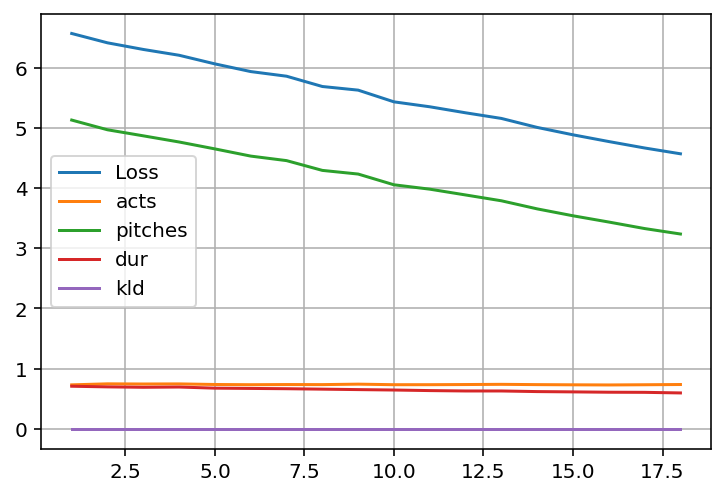

In [268]:
plt.plot(range(1, len(m['losses'])+1), m['losses'], label='Loss')
plt.plot(range(1, len(m['acts_losses'])+1), m['acts_losses'], label='acts')
plt.plot(range(1, len(m['pitches_losses'])+1), m['pitches_losses'], label='pitches')
plt.plot(range(1, len(m['dur_losses'])+1), m['dur_losses'], label='dur')
plt.plot(range(1, len(m['kld_losses'])+1), m['kld_losses'], label='kld')
plt.grid()
plt.legend()

# Stuff

In [ ]:
from typing import Optional, Union, Tuple
from torch_geometric.typing import OptTensor, Adj

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter
from torch_scatter import scatter
from torch_sparse import SparseTensor, matmul, masked_select_nnz
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import glorot, zeros


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')


class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    .. note::
        This implementation is as memory-efficient as possible by iterating
        over each individual relation type.
        Therefore, it may result in low GPU utilization in case the graph has a
        large number of relations.
        As an alternative approach, :class:`FastRGCNConv` does not iterate over
        each individual type, but may consume a large amount of memory to
        compensate.
        We advise to check out both implementations to see which one fits your
        needs.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
            In case no input features are given, this argument should
            correspond to the number of nodes in your graph.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        num_bases (int, optional): If set to not :obj:`None`, this layer will
            use the basis-decomposition regularization scheme where
            :obj:`num_bases` denotes the number of bases to use.
            (default: :obj:`None`)
        num_blocks (int, optional): If set to not :obj:`None`, this layer will
            use the block-diagonal-decomposition regularization scheme where
            :obj:`num_blocks` denotes the number of blocks to use.
            (default: :obj:`None`)
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"mean"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        num_bases: Optional[int] = None,
        num_blocks: Optional[int] = None,
        aggr: str = 'mean',
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if num_bases is not None and num_blocks is not None:
            raise ValueError('Can not apply both basis-decomposition and '
                             'block-diagonal-decomposition at the same time.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.num_blocks = num_blocks

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.in_channels_l = in_channels[0]

        if num_bases is not None:
            self.weight = Parameter(
                torch.Tensor(num_bases, in_channels[0], out_channels))
            self.comp = Parameter(torch.Tensor(num_relations, num_bases))

        elif num_blocks is not None:
            assert (in_channels[0] % num_blocks == 0
                    and out_channels % num_blocks == 0)
            self.weight = Parameter(
                torch.Tensor(num_relations, num_blocks,
                             in_channels[0] // num_blocks,
                             out_channels // num_blocks))
            self.register_parameter('comp', None)

        else:
            self.weight = Parameter(
                torch.Tensor(num_relations, in_channels[0], out_channels))
            self.register_parameter('comp', None)

        if root_weight:
            self.root = Param(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Param(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.comp)
        glorot(self.root)
        zeros(self.bias)


    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None):
        r"""
        Args:
            x: The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.
            edge_type: The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """

        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)

        weight = self.weight
        if self.num_bases is not None:  # Basis-decomposition =================
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:  # Block-diagonal-decomposition =====

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:  # No regularization/Basis-decomposition ========================
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_relations={self.num_relations})')

next edges

In [ ]:
import itertools

a = np.random.randint(2, size=(4,8))
a_t = a.transpose()
print(a_t)
inds = np.stack(np.where(a_t == 1)).transpose()
ts_acts = np.any(a_t, axis=1)
ts_inds = np.where(ts_acts)[0]

labels = np.arange(32).reshape(4, 8).transpose()
print(labels)

next_edges = []
for i in range(len(ts_inds)-1):
    ind_s = ts_inds[i]
    ind_e = ts_inds[i+1]
    s = inds[inds[:,0] == ind_s]
    e = inds[inds[:,0] == ind_e]
    e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
    edges = [(labels[tuple(e[0])],labels[tuple(e[1])], ind_e-ind_s) for e in e_inds]
    next_edges.extend(edges)

print(next_edges)
    

[[0 1 1 1]
 [1 1 1 1]
 [1 1 0 0]
 [1 1 1 1]
 [0 1 0 1]
 [1 0 0 0]
 [1 1 1 0]
 [0 0 0 0]]
[[ 0  8 16 24]
 [ 1  9 17 25]
 [ 2 10 18 26]
 [ 3 11 19 27]
 [ 4 12 20 28]
 [ 5 13 21 29]
 [ 6 14 22 30]
 [ 7 15 23 31]]
[(8, 1, 1), (8, 17, 1), (8, 25, 1), (16, 1, 1), (16, 9, 1), (16, 25, 1), (24, 1, 1), (24, 9, 1), (24, 17, 1), (1, 10, 1), (9, 2, 1), (17, 2, 1), (17, 10, 1), (25, 2, 1), (25, 10, 1), (2, 11, 1), (2, 19, 1), (2, 27, 1), (10, 3, 1), (10, 19, 1), (10, 27, 1), (3, 12, 1), (3, 28, 1), (11, 28, 1), (19, 12, 1), (19, 28, 1), (27, 12, 1), (12, 5, 1), (28, 5, 1), (5, 14, 1), (5, 22, 1)]


onset edges

In [ ]:
onset_edges = []
print(a_t)
print(labels)

for i in ts_inds:
    ts_acts_inds = list(inds[inds[:,0] == i])
    if len(ts_acts_inds) < 2:
        continue
    e_inds = list(itertools.combinations(ts_acts_inds, 2))
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], 0) for e in e_inds]
    inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
    onset_edges.extend(edges)
    onset_edges.extend(inv_edges)

print(onset_edges)


[[0 1 1 1]
 [1 1 1 1]
 [1 1 0 0]
 [1 1 1 1]
 [0 1 0 1]
 [1 0 0 0]
 [1 1 1 0]
 [0 0 0 0]]
[[ 0  8 16 24]
 [ 1  9 17 25]
 [ 2 10 18 26]
 [ 3 11 19 27]
 [ 4 12 20 28]
 [ 5 13 21 29]
 [ 6 14 22 30]
 [ 7 15 23 31]]
[(8, 16, 0), (8, 24, 0), (16, 24, 0), (16, 8, 0), (24, 8, 0), (24, 16, 0), (1, 9, 0), (1, 17, 0), (1, 25, 0), (9, 17, 0), (9, 25, 0), (17, 25, 0), (9, 1, 0), (17, 1, 0), (25, 1, 0), (17, 9, 0), (25, 9, 0), (25, 17, 0), (2, 10, 0), (10, 2, 0), (3, 11, 0), (3, 19, 0), (3, 27, 0), (11, 19, 0), (11, 27, 0), (19, 27, 0), (11, 3, 0), (19, 3, 0), (27, 3, 0), (19, 11, 0), (27, 11, 0), (27, 19, 0), (12, 28, 0), (28, 12, 0), (6, 14, 0), (6, 22, 0), (14, 22, 0), (14, 6, 0), (22, 6, 0), (22, 14, 0)]


track edges

In [ ]:
print(a_t)
print(labels)
track_edges = []

for track in range(a_t.shape[1]):
    tr_inds = list(inds[inds[:,1] == track])
    e_inds = [(tr_inds[i],
               tr_inds[i+1]) for i in range(len(tr_inds)-1)]
    print(e_inds)
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], e[1][0]-e[0][0]) for e in e_inds]
    track_edges.extend(edges)

print(track_edges)

[[1 1 1 1]
 [1 0 0 1]
 [0 1 0 0]
 [0 0 0 0]
 [1 1 0 0]
 [0 0 1 1]
 [0 0 1 0]
 [0 0 1 1]]
[[ 0  8 16 24]
 [ 1  9 17 25]
 [ 2 10 18 26]
 [ 3 11 19 27]
 [ 4 12 20 28]
 [ 5 13 21 29]
 [ 6 14 22 30]
 [ 7 15 23 31]]
[(array([0, 0]), array([1, 0])), (array([1, 0]), array([4, 0]))]
[(array([0, 1]), array([2, 1])), (array([2, 1]), array([4, 1]))]
[(array([0, 2]), array([5, 2])), (array([5, 2]), array([6, 2])), (array([6, 2]), array([7, 2]))]
[(array([0, 3]), array([1, 3])), (array([1, 3]), array([5, 3])), (array([5, 3]), array([7, 3]))]
[(0, 1, 1), (1, 4, 3), (8, 10, 2), (10, 12, 2), (16, 21, 5), (21, 22, 1), (22, 23, 1), (24, 25, 1), (25, 29, 4), (29, 31, 2)]


In [ ]:
track_edges = np.array(track_edges)
onset_edges = np.array(onset_edges)
np.concatenate((track_edges, onset_edges)).shape

(50, 3)

In [ ]:
pip install pypianoroll

In [ ]:
import pypianoroll

In [ ]:
multitrack = pypianoroll.read("tests_fur-elise.mid")
print(multitrack)

In [ ]:
multitrack.tracks[0].pianoroll

In [ ]:
multitrack.plot()

In [ ]:
multitrack.trim(0, 12 * multitrack.resolution)
multitrack.binarize()

In [ ]:
multitrack.plot()

In [ ]:
multitrack.tracks[0].pianoroll.shape